In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from scipy import stats

import precision_functions as prefun

import importlib
importlib.reload(prefun)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

### Constants

In [2]:
EVENT = "rastoc:stillness-position-lost"
TRIAL_TAG = "validation-stimulus"  # Opcion: "fixation-stimulus"  # Es el momento donde aparece la cruz de fijacion
FIRST_SAMPLE = 500
MAX_VAR = 75
MAX_PLOTS = None
VERBOSE = False
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))
LOAD_PATH = "raw_data/gus_webcam3_computer3_chrome_ubuntu.csv"  # ·str(ALL_FILES_RAW[1])
LOAD_INFO = LOAD_PATH.split("/")[1].split("_")

### Data load

In [3]:
print(LOAD_PATH)
df = pd.read_csv(LOAD_PATH)
df.head(5)

raw_data/gus_webcam3_computer3_chrome_ubuntu.csv


,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,recorded_at,source_code_version,ip,user_agent,device,browser,browser_version,platform,platform_version,load_time,success,jspsych_start_time,item_width_mm,item_height_mm,item_width_px,px2mm,view_dist_mm,item_width_deg,px2deg,win_width_deg,win_height_deg,stimulus,response_type,key_press,avg_frame_time,center_x,center_y,rastoc-type,stimulus-coordinate,calibration-id,calibration-point-id,inner-width,inner-height,webgazer_data,webgazer_targets,session-id,validation-id,tracked-trial-id,trial-tag,start-x,start-y,events
0,18126.0,"{""name-id"":""prueba_a_conciencia"",""webcam-id"":""...",survey-html-form,0,18129,0.0-0.0,26,1,2023-01-24 16:58:28,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,webgazer-init-camera,1,47787,0.0-1.0,26,1,2023-01-24 16:58:28,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,444.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,fullscreen,2,50358,0.0-2.0,26,1,2023-01-24 16:58:28,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,events-tracking-start,3,50359,0.0-3.0,26,1,2023-01-24 16:58:28,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,2023-01-24T16:58:29.254Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52150.0,NaN,virtual-chinrest,4,102512,0.0-4.0,26,1,2023-01-24 16:58:28,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,85.6,53.98,348.0,4.07,589.69,8.302555,41.914808,45.8072,25.76655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check rastoc events

In [4]:
events  = prefun.get_rastoc_events(df, EVENT)
print("len(events):", len(events))

len(events): 24


### Precision experiment analysis

In [21]:

for file in ALL_FILES_RAW:
    LOAD_PATH = str(file)
    print(LOAD_PATH)
    df = pd.read_csv(LOAD_PATH)
    
    try:
        print(df['response'].iloc[0])
    except KeyError:
        print('response is not a column of df')
        continue

    df_res = prefun.calculate_and_plot_errors(df, 
                                    TRIAL_TAG,
                                    first_sample=FIRST_SAMPLE,
                                    max_var=MAX_VAR,
                                    max_plots=MAX_PLOTS, 
                                    verbose=VERBOSE)

                

    df_res.insert(0, 'abs', [i+1 for i in df_res.index])
    i = 1
    rounds = []
    for num in range(1, 577):
        rounds.append(i)
        if num % 72 == 0:
            i = i + 1
    df_res.insert(1, 'block', (df_res['trials']-1)%8 + 1)
    df_res.insert(2, 'round', rounds)
    df_res[['presented_point_x','presented_point_y']] = pd.DataFrame(df_res['presented_point'].tolist())
    points_position_dict = dict(zip(df_res['presented_point'].unique(), range(1,10)))
    df_res['target_id'] = df_res["presented_point"].map(points_position_dict)

    print(f"Error: {df_res['total_errors_pxs_mean'].mean():.2f} +- {df_res['total_errors_pxs_mean'].std():.2f}")
    SAVE_PATH = f"analyzed/analyzed_{LOAD_PATH.split('/')[-1]}"
    print(f'Saved: {SAVE_PATH}')
    df_res.to_csv(SAVE_PATH, index=False)

raw_data/juan_webcam8_computer_3_chrome_ubuntu.csv
response is not a column of df
raw_data/gus_webcam3_computer3_chrome_ubuntu.csv
{"name-id":"prueba_a_conciencia","webcam-id":"3","computer-id":"3","web-browser":"Chrome","operating-system":"Ubuntu"}
processing ...
len(horizontal_errors_pxs): 576
Error: 162.59 +- 96.26
Saved: analyzed/analyzed_gus_webcam3_computer3_chrome_ubuntu.csv
raw_data/gus_webcam8.csv
{"name-id":"Gustavo","webcam-id":"8","computer-id":"3","web-browser":"Chrome","operating-system":"Ubuntu"}
processing ...
len(horizontal_errors_pxs): 576
Error: 134.29 +- 70.53
Saved: analyzed/analyzed_gus_webcam8.csv
raw_data/gus_webcam9_computer3_chrome_ubuntu.csv
{"name-id":"Gustavo","webcam-id":"9","computer-id":"3","web-browser":"Chrome","operating-system":"Ubuntu"}
processing ...
len(horizontal_errors_pxs): 576
Error: 153.29 +- 79.14
Saved: analyzed/analyzed_gus_webcam9_computer3_chrome_ubuntu.csv
raw_data/juan_webcam3.csv
{"name-id":"Juan ","webcam-id":"3","computer-id":"3","w

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7ff1ad5f1ca0>
Traceback (most recent call last):
  File "/home/gus/enviroments/et_precision/lib/python3.8/site-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


### SAVE

In [197]:
SAVE_PATH = f"analyzed/analyzed_{LOAD_PATH.split('/')[-1]}"
print(f'Saved: {SAVE_PATH}')
df_res.to_csv(SAVE_PATH, index=False)

Saved: analyzed/analyzed_gus_local_webcam4_computer3_chrome_ubuntu.csv


### Analysis

In [4]:
df_res_gus = pd.read_csv('./analyzed/analyzed_gus_webcam4.csv')
df_res_juan = pd.read_csv('./analyzed/analyzed_juan_webcam4.csv')

df_res_all = [df_res_gus,  df_res_juan]

new_indexes = []

for i, df_res_ in enumerate(df_res_all):
    cols = []
    for i in sorted(df_res_['presented_point_x'].unique()):
        col = []
        for j in sorted(df_res_['presented_point_y'].unique(), reverse=True):
            col.append((i, j))
        cols.append(col)

    new_index_ = np.concatenate(pd.DataFrame(cols).T.values)
    new_index_ = [str(i) for i in new_index_]
    new_indexes.append(new_index_)

In [42]:
df_res_juan.head(4)

,abs,block,round,trials,first_sample,max_var,presented_point,time_between_samples_mean,time_between_samples_std,sampling_rate_mean,sampling_rate_std,sampling_rate_min,sampling_rate_max,last_time_sample,horizontal_errors_pxs,vertical_errors_pxs,total_errors_pxs,horizontal_errors_pxs_mean,horizontal_errors_pxs_std,vertical_errors_pxs_mean,vertical_errors_pxs_std,total_errors_pxs_mean,total_errors_pxs_std,webgazer_x,webgazer_y,webgazer_t,metadata,px2degree,presented_point_x,presented_point_y,target_id
0,1,1.0,1,1.0,500,75,"(1317.0, 536.0)",52.882353,10.835032,19.707078,4.038429,13.157895,29.411765,899,[76. 63. 87. 68. 3. 40. 25. 53.],[ 73. 17. 4. 24. 82. 182. 140. 38.],[105.38026381 65.2533524 87.09190548 72.11...,51.875000,26.107650,70.000000,59.057176,100.708104,40.227513,[1062 1027 979 1053 1057 1075 1230 1265 1301 ...,[541 501 514 649 681 645 648 638 662 633 609 5...,[ 0 68 128 181 230 280 328 384 433 480 552 5...,"{""name-id"":""Juan"",""webcam-id"":""4"",""computer-id...",35.66,1317.0,536.0,1
1,2,1.0,1,1.0,500,75,"(603.0, 179.0)",48.000000,16.951944,29.239535,33.001318,13.157895,166.666667,912,[114. 123. 125. 81. 55. 45. 11. 37. 41.],[ 39. 11. 14. 114. 100. 88. 57. 82. 193.],[120.48651377 123.49089035 125.78155668 139.84...,70.222222,39.653437,77.555556,53.402270,118.654483,35.935161,[1194 1231 1247 1315 1339 1292 1295 964 719 ...,[602 625 609 634 651 665 678 608 404 353 231 2...,[ 0 64 95 127 164 192 244 318 368 418 466 5...,"{""name-id"":""Juan"",""webcam-id"":""4"",""computer-id...",35.66,603.0,179.0,2
2,3,1.0,1,1.0,500,75,"(603.0, 536.0)",48.263158,13.529080,22.388220,6.293829,12.345679,35.714286,917,[86. 58. 89. 22. 47. 49. 44. 89. 60. 94. 69.],[163. 91. 23. 3. 36. 27. 79. 99. 24. ...,[184.29595763 107.91200119 91.92388155 22.20...,64.272727,22.132210,56.727273,45.493438,90.722331,40.962339,[643 629 609 636 602 650 698 710 707 689 661 6...,[397 416 362 308 259 332 640 764 715 699 627 5...,[ 0 81 144 217 264 299 349 401 451 502 551 6...,"{""name-id"":""Juan"",""webcam-id"":""4"",""computer-id...",35.66,603.0,536.0,3
3,4,1.0,1,1.0,500,75,"(1317.0, 179.0)",43.904762,12.023409,24.647286,7.087086,14.705882,40.000000,922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ 661 740 732 693 635 630 773 1139 1238 ...,[477 513 499 431 392 438 487 590 312 244 278 3...,[ 0 66 91 141 195 229 262 297 334 369 397 4...,"{""name-id"":""Juan"",""webcam-id"":""4"",""computer-id...",35.66,1317.0,179.0,4


In [59]:
# TODO: Graficar errores para despues hacer los ovalos https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Ellipse.html

err_x = df_res_juan.query("presented_point == '(1317.0, 536.0)'")['horizontal_errors_pxs'].dropna(axis=0).str.replace(".", ",").str.replace(
    "NaN", "None"
).astype(str).map(eval).sum()

err_y = df_res_juan.query("presented_point == '(1317.0, 536.0)'")['vertical_errors_pxs'].dropna(axis=0).str.replace(".", ",").str.replace(
    "NaN", "None"
).astype(str).map(eval).sum()

/tmp/ipykernel_25222/4216568977.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  err_x = df_res_juan.query("presented_point == '(1317.0, 536.0)'")['horizontal_errors_pxs'].dropna(axis=0).str.replace(".", ",").str.replace(
/tmp/ipykernel_25222/4216568977.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  err_y = df_res_juan.query("presented_point == '(1317.0, 536.0)'")['vertical_errors_pxs'].dropna(axis=0).str.replace(".", ",").str.replace(


In [63]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)



AttributeError: 'list' object has no attribute 'size'

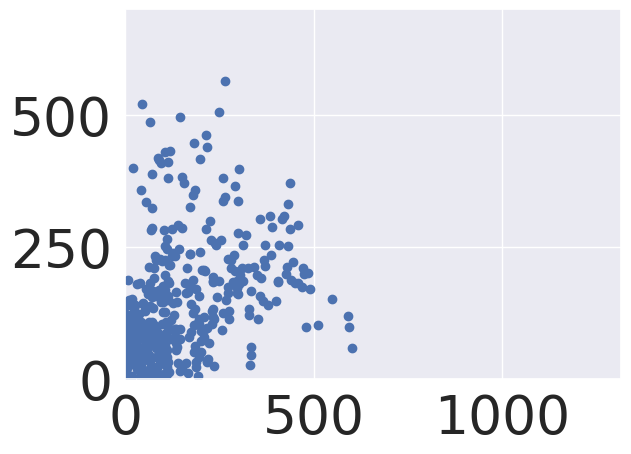

In [64]:
ax = plt.scatter(err_x, err_y)
plt.xlim(0, 1317)
plt.ylim(0, 700)


confidence_ellipse(err_x, err_y, ax)

In [31]:
x_err = df_res_juan["horizontal_errors_pxs"].dropna(axis=0).str.replace(".", ",").str.replace(
    "NaN", "None"
).astype(str).map(eval).sum()

y_err = df_res_juan["vertical_errors_pxs"].dropna(axis=0).str.replace(".", ",").str.replace(
    "NaN", "None"
).astype(str).map(eval).sum()

plt.scatter(x_err, y_err)
plt.xlim()
plt.ylim()


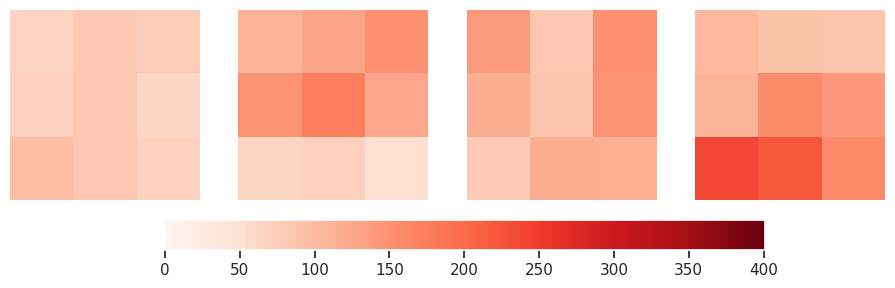

In [30]:
sns.set(font_scale=1)   

columnas = ["horizontal_errors_pxs_mean", "vertical_errors_pxs_mean"]
VMIN = 0
VMAX = 400
CMAP = "Reds"

iterator = 0
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 4, figure=fig)
for i, df_res_ in enumerate(df_res_all):
    for j in range(2):
        ax1 = fig.add_subplot(gs[0, iterator])
        iterator +=1
        sns.heatmap(
            df_res_.groupby("presented_point")[columnas[j]]
            .mean()
            .reindex(new_indexes[i])
            .values.reshape(3, 3),
            square=True,
            cbar=False,
            cmap=CMAP,
            # annot=True,
            xticklabels=False,
            yticklabels=False,
            ax=ax1,
            vmin=VMIN,
            vmax=VMAX,
        )
        # for t in ax1.texts:
        #     t.set_text("●")



img = plt.imshow(np.array([[VMIN, VMAX + 1]]), cmap=CMAP)
cax = plt.axes([0.1, 0.35, 0.7, 0.2])
plt.gca().set_visible(False)
plt.colorbar(ax=cax, orientation='horizontal')

fig.subplots_adjust(right=0.75)
# plt.colorbar(ax=ax1, cax=cax,)
plt.show()


<Figure size 1400x600 with 0 Axes>

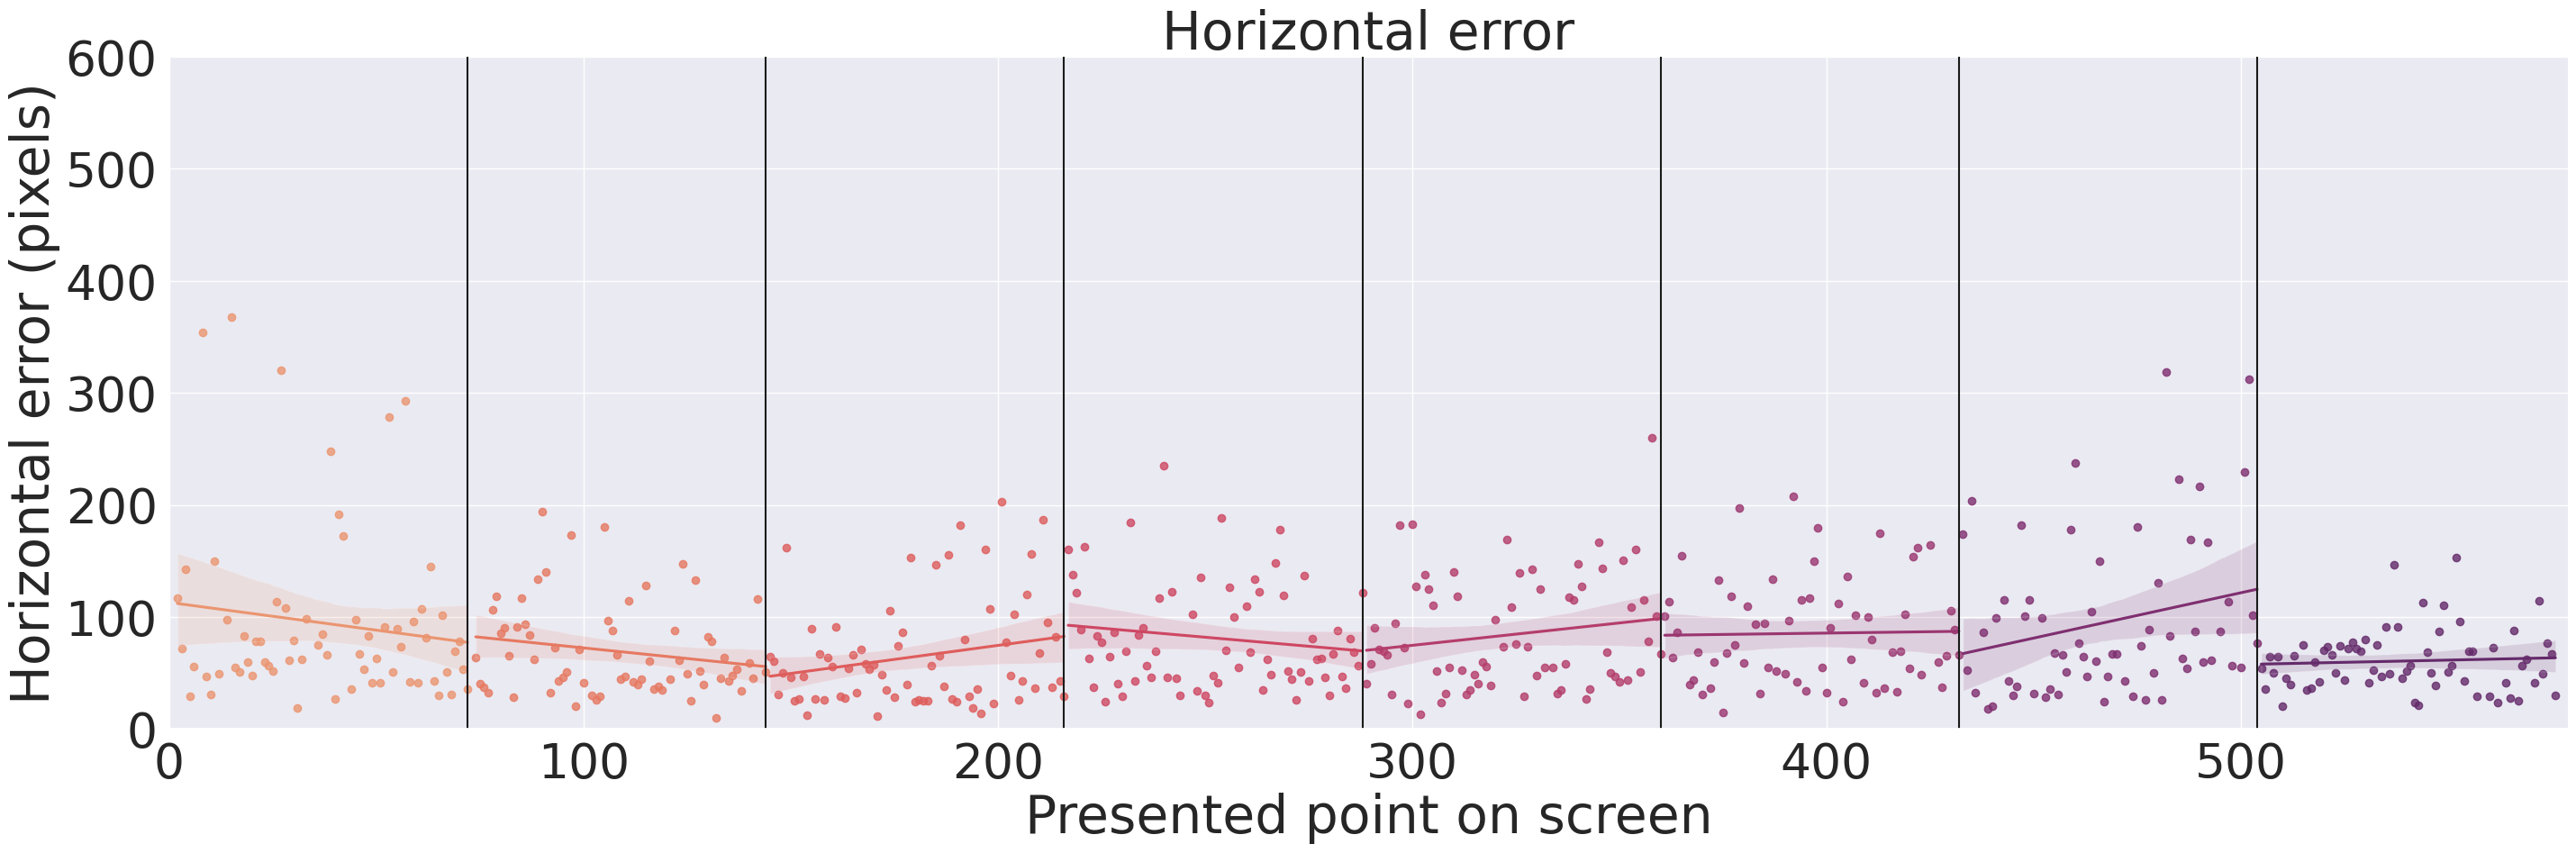

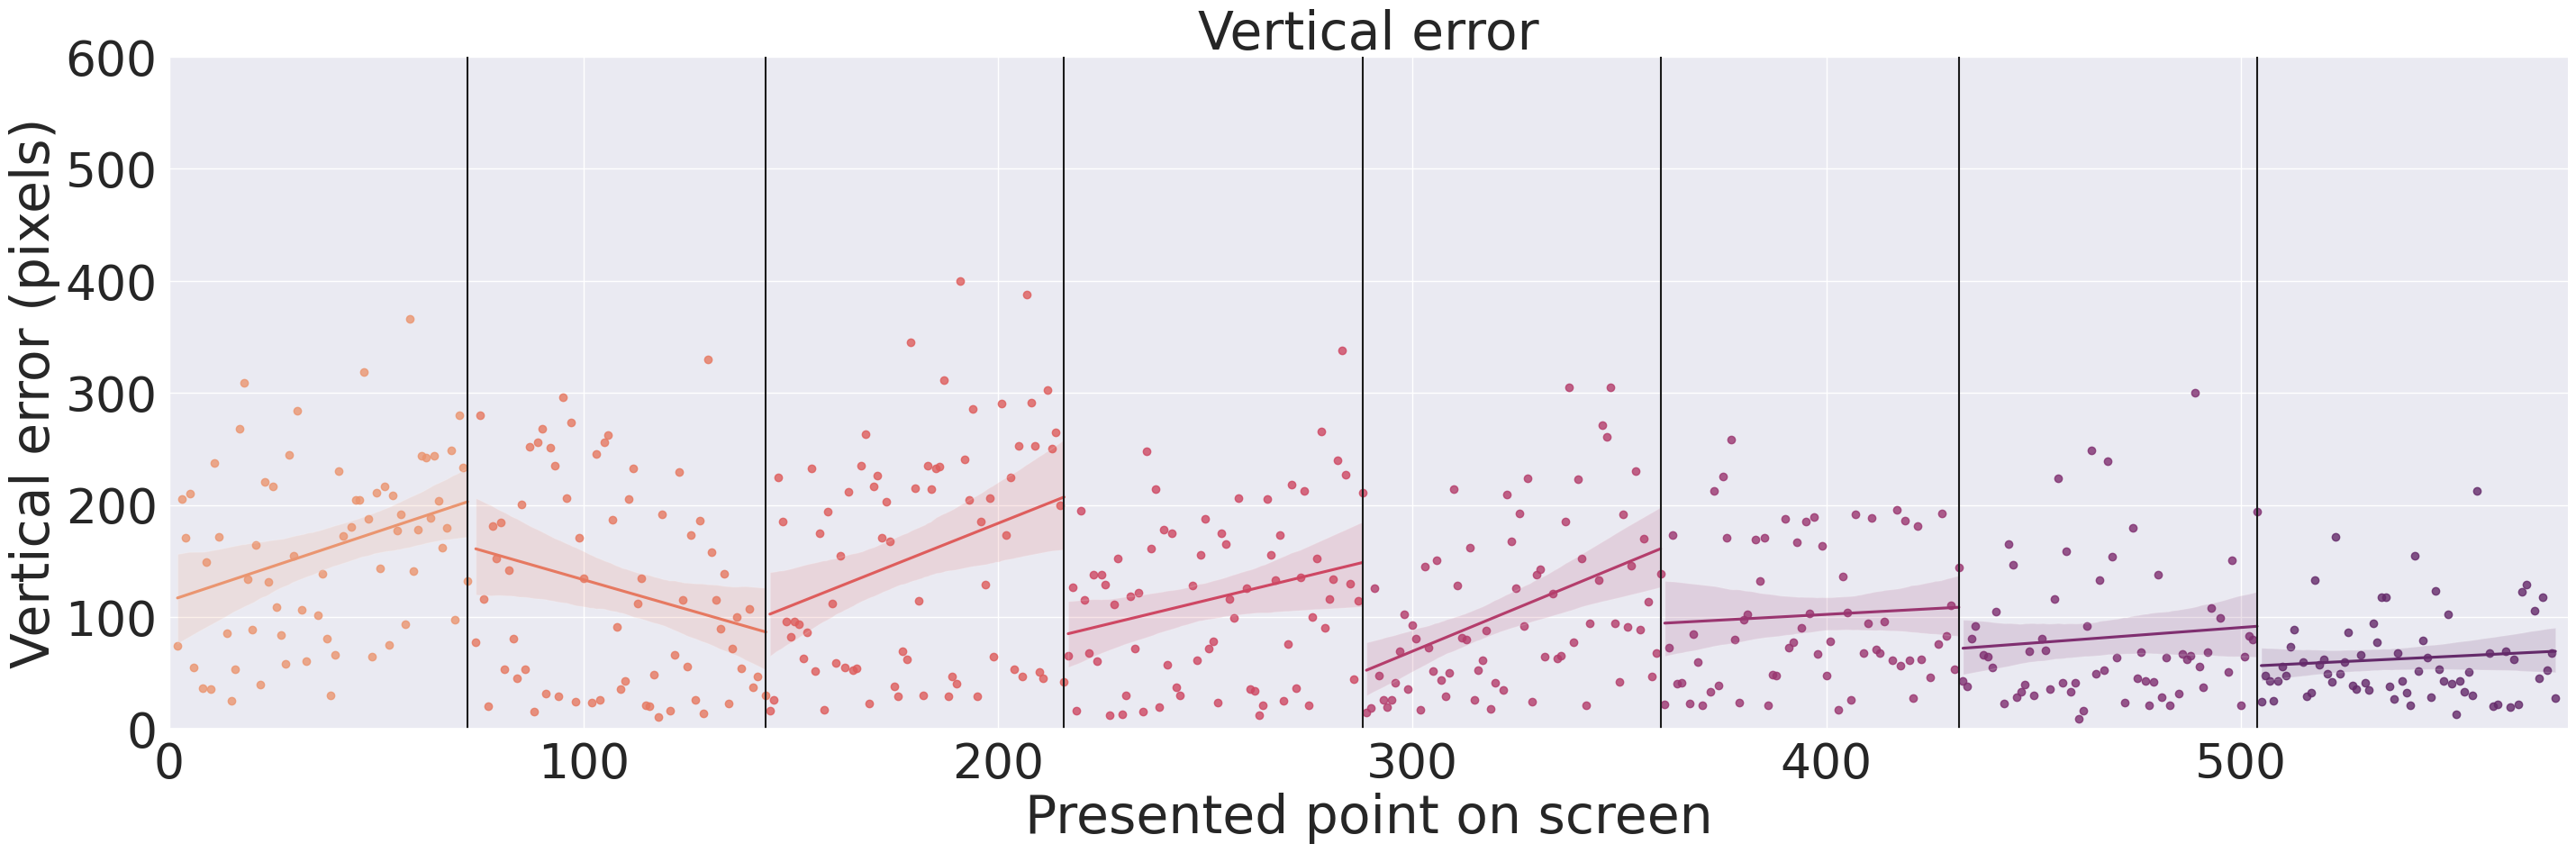

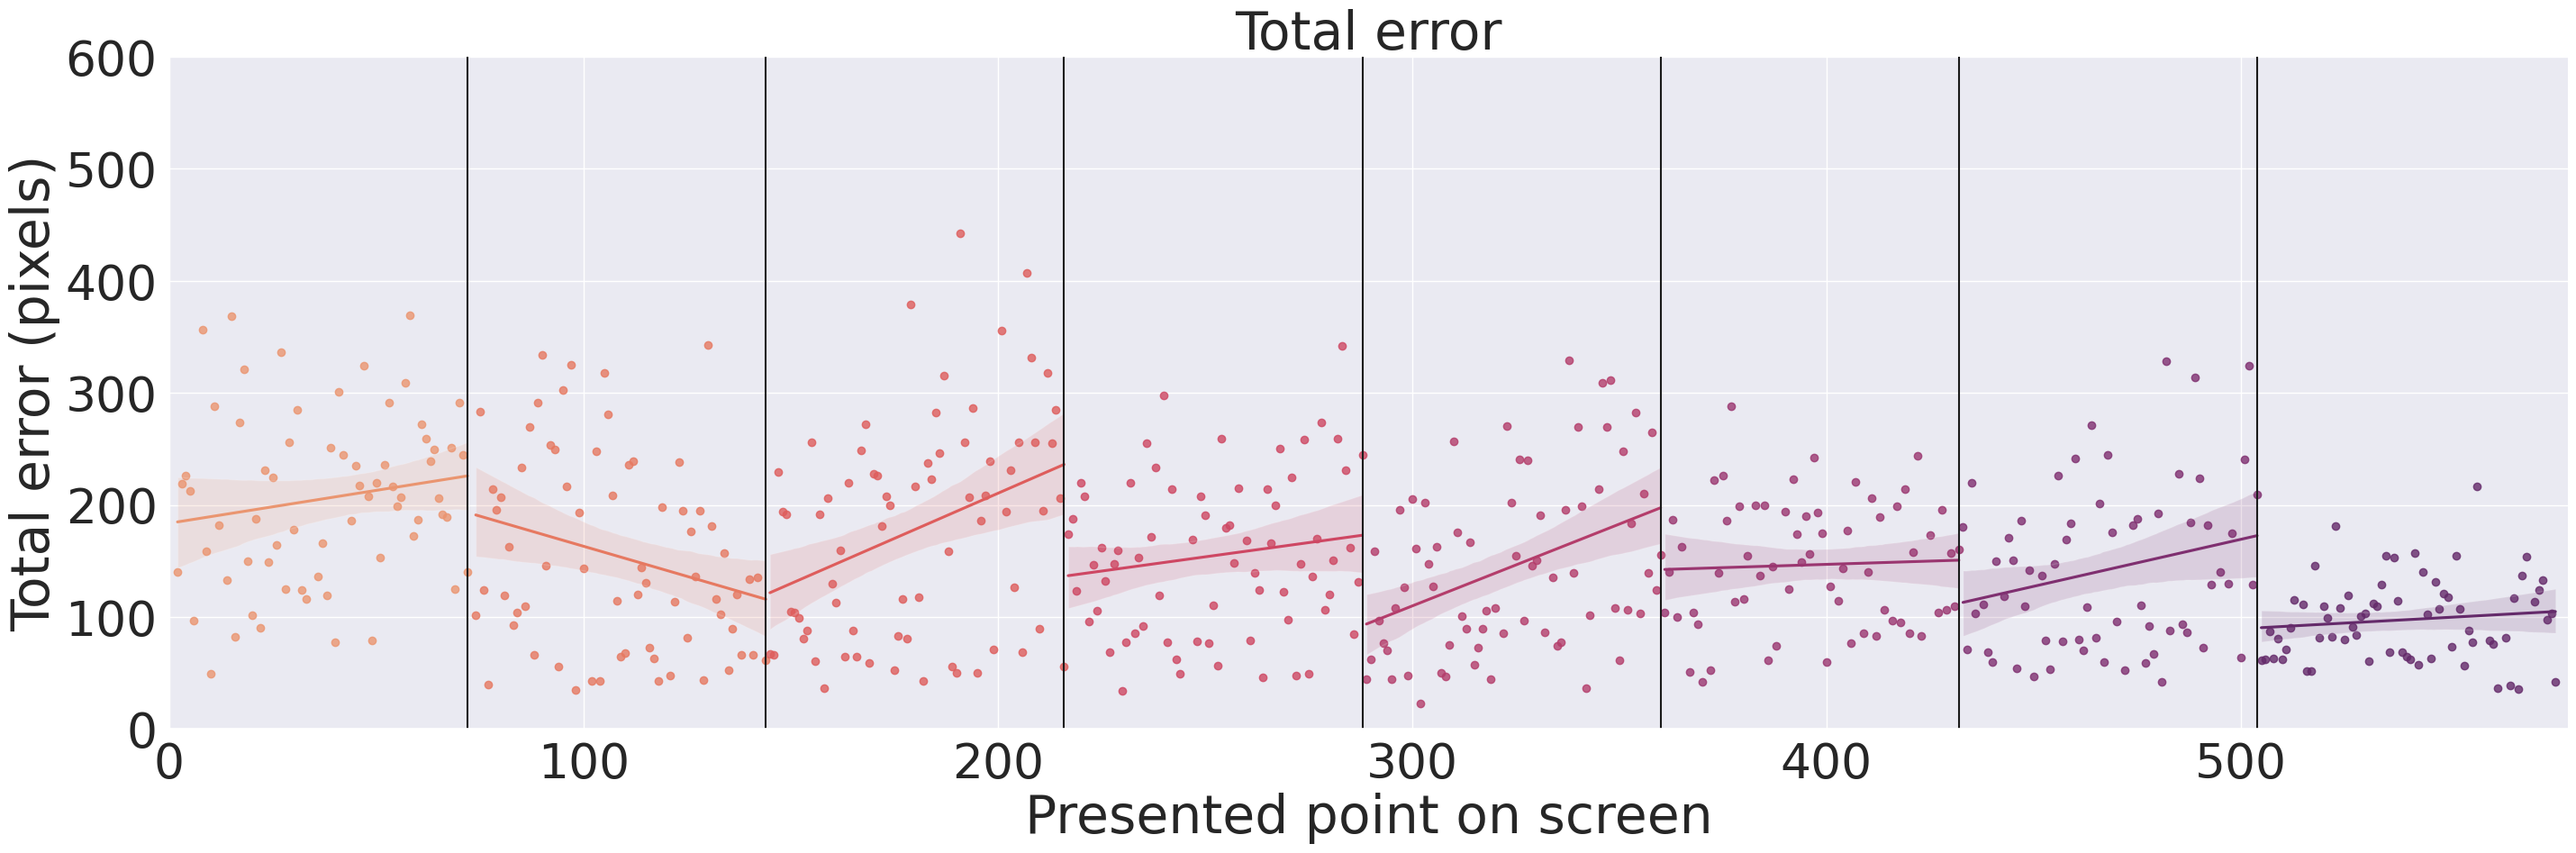

In [37]:
# df_res = pd.read_csv('./analyzed/analyzed_juan_webcam9.csv')
df_res = pd.read_csv('./analyzed/analyzed_gus_webcam9_computer3_chrome_ubuntu.csv')

plt.figure(figsize=(14, 6))
sns.set(font_scale=3.5)   

g = sns.lmplot(data=df_res, y='horizontal_errors_pxs_mean', x="abs", hue='round',height=10, aspect=3, palette='flare',legend=False)
plt.vlines([i*72 for i in range(1,8)], ymin=0 , ymax=600, colors='k')
plt.xlim([0, 579])
plt.ylim([0, 600])
plt.xlabel('Presented point on screen')
plt.ylabel('Horizontal error (pixels)')
plt.title('Horizontal error')
plt.savefig(f"horizontal_error_{eval(df_res['metadata'].iloc[0])['name-id']}_webcam{eval(df_res['metadata'].iloc[0])['webcam-id']}.png")
plt.show()

sns.lmplot(data=df_res, y='vertical_errors_pxs_mean', x="abs", hue='round',height=10, aspect=3, palette='flare',legend=False)
plt.vlines([i*72 for i in range(1,8)], ymin=0 , ymax=600, colors='k')
plt.xlabel('Presented point on screen')
plt.ylabel('Vertical error (pixels)')
plt.title('Vertical error')
plt.xlim([0, 579])
plt.ylim([0, 600])
plt.savefig(f"vertical_error_{eval(df_res['metadata'].iloc[0])['name-id']}_webcam{eval(df_res['metadata'].iloc[0])['webcam-id']}.png")
plt.show()

sns.lmplot(data=df_res, y='total_errors_pxs_mean', x="abs", hue='round',height=10, aspect=3, palette='flare',legend=False)
plt.vlines([i*72 for i in range(1,8)], ymin=0 , ymax=600, colors='k')
plt.xlabel('Presented point on screen')
plt.ylabel('Total error (pixels)')
plt.title('Total error')
plt.xlim([0, 579])
plt.ylim([0, 600])
plt.show()

### Other

In [ ]:
df_res_ = df_res[['abs', 'block', 'round','target_id', 'horizontal_errors_pxs', 'vertical_errors_pxs', 'total_errors_pxs']]

In [ ]:
df_res['horizontal_errors_pxs_mean_norm'] = df_res['horizontal_errors_pxs_mean'] / df_res['horizontal_errors_pxs_mean'].max()
df_res['vertical_errors_pxs_mean_norm'] = df_res['vertical_errors_pxs_mean'] / df_res['vertical_errors_pxs_mean'].max()

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_res['abs'],df_res['horizontal_errors_pxs_mean'])

slope


### Analysis

In [6]:
ALL_FILES_ANALYZED = list(Path("./analyzed").glob("*.csv"))
ALL_FILES_ANALYZED

df_all_res = prefun.evaluate_experiment_instances(ALL_FILES_ANALYZED)

analyzed/analyzed_juan_webcam9_computer3_ubuntu.csv
Error x: 97.52 +- 67.40
Error y: 126.23 +- 108.76
Error total: 175.64 +- 112.13
Sampling rate: 23.30 +- 2.08
px2degree: 41.81
---
analyzed/analyzed_gus_webcam_3.csv
px2degree not in df
analyzed/analyzed_juan_local_webcam4_computer3_chrome_ubuntu.csv
px2degree not in df
analyzed/analyzed_juan_webcam4.csv
Error x: 115.75 +- 93.67
Error y: 143.29 +- 134.85
Error total: 204.16 +- 143.68
Sampling rate: 22.76 +- 2.09
px2degree: 35.66
---
analyzed/analyzed_juan_webcam8_computer3_chrome_ubuntu.csv
Error x: 114.28 +- 72.31
Error y: 132.81 +- 97.61
Error total: 193.28 +- 99.35
Sampling rate: 22.59 +- 2.40
px2degree: 38.12
---
analyzed/analyzed_juan_webcam3.csv
Error x: 151.99 +- 111.98
Error y: 170.34 +- 143.36
Error total: 252.42 +- 153.45
Sampling rate: 25.20 +- 2.18
px2degree: 40.88
---
analyzed/analyzed_juan_webcam9_repe.csv
Error x: 97.52 +- 67.40
Error y: 126.23 +- 108.76
Error total: 175.64 +- 112.13
Sampling rate: 23.30 +- 2.08
px2degre

### Save

In [ ]:
SAVE_PATH = f"analyzed/analyzed_{LOAD_PATH.split('/')[-1]}"
print(f'Saved: {SAVE_PATH}')
df_res.to_csv(SAVE_PATH, index=False)

### Cosas

In [ ]:

df = pd.read_csv('/home/gus/Downloads/antisacadas_91.csv')
df.head(5)

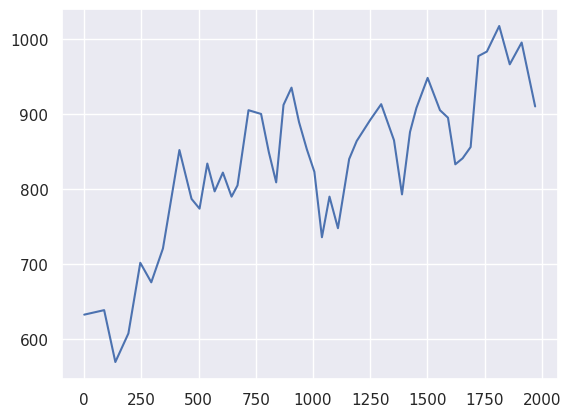

In [36]:
trial = 100
xs = [i['x'] for i in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval).iloc[trial]]
ys = [i['y'] for i in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval).iloc[trial]]
ts = [i['t'] for i in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval).iloc[trial]]

plt.plot(ts, xs)
# plt.xlim(0, int(df[~df['webgazer_data'].isna()]['viewportWidth'].iloc[-1]))
# plt.ylim(0, df[~df['webgazer_data'].isna()]['viewportHeight'].iloc[-1])
# plt.colorbar()
plt.show()